In [1]:
import json
import xml.etree.ElementTree as ET
from pathlib import Path

input_path = '/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/metadata/'
simulation_setup = "lowCongestion_5minDemand"

config = json.load(open(input_path + "/config.json"))
config["NETWORK"] = Path(config["NETWORK"])
config["SUMO"] = Path(config["SUMO"])
# [CO] updated simulation setup to use OD scenario #4: 42-dimensional  + low congestion.
#sim_setup = json.load(open(input_path + "simulation_setups_co_gt.json"))
sim_setup = json.load(open(input_path + f"simulation_setups_{simulation_setup}.json"))


In [2]:
# excluding warmup period of 15min
# so you need to simulate for at least 15min now. 
warm_up_sec = 15*60 # duration in seconds

# duration, in seconds, of each edge simulation output statistics
# this value should be consistent with what is defined in additional.add.xml
edge_stats_freq = 300

In [17]:
## Main simulator function
import os
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
import torch

from pandas import DataFrame
from pathlib import Path


def run_sumo(config, sim_setup, prefix_input, prefix_output):
    od2trips_cmd = (
        #f"od2trips --no-step-log  --spread.uniform "
        f"od2trips  --spread.uniform "
        #Loads TAZ (districts)
        f"--taz-files {config['NETWORK']}/{sim_setup['taz']} " 
        # Loads O/D-matrix in tazRelation format fromFILE(s)
        f"--tazrelation-files {config['NETWORK']}/{sim_setup[f'{prefix_input}_od']} "
        # Writes trip definitions into FILE
        f"-o {config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml " 
    )

    # Run SUMO to generate outputs
    sumo_run = (
        # Prefix which is applied to all output files. 
        f"sumo --output-prefix {prefix_output}_{sim_setup['prefix_sim_run']}_ " 
        # Do not check whether routes are connected
        f"--ignore-route-errors=true "
        # Load road network description from FILE
        f"--net-file={config['NETWORK']/sim_setup['net']} "
        # Load routes descriptions from FILE(s)
        f"--routes={config['NETWORK']}/{prefix_output}_{sim_setup['prefix_sim_run']}_od_trips.trips.xml "
        #  -b Defines the begin time in seconds; The simulation starts at this time
        # -e Defines the end time in seconds; The simulation ends at this time
        f"-b {sim_setup['start_sim_sec']} -e {sim_setup['end_sim_sec']} "
        # Load further descriptions from FILE(s)
        f"--additional-files {config['NETWORK']/sim_setup['add']} "
        f"--duration-log.statistics "
        f"--xml-validation never "
        # Save single vehicle route info into FILE
        f"--vehroutes {config['NETWORK']}/routes.vehroutes.xml "
        f"--verbose "
        # Disables output of warnings
        f"--no-warnings "
        # Faster simulation (i.e. less detailed)
        f"--mesosim true "
    
    )
        # f"--seed {seed}"

    try:
        print(od2trips_cmd)
        os.system(od2trips_cmd)
    except:
        print("Unable to create trips file")
    else:
        print("###### Running SUMO #######")
        print(sumo_run)
        os.system(sumo_run)


def parse_loop_data_xml_to_pandas(config: dict,loop_file: dict) -> DataFrame: 
    """Read the Loop Detectors Data: Each SUMO run produces a file with the
    traffic counts. This function reads the corresponding traffic counts file
    averages across simulation replications
    
    """

    output_file =(config["NETWORK"] / "loopOutputs.csv")
    ## See output explanation:
    # https://sumo.dlr.de/docs/Simulation/Output/Lane-_or_Edge-based_Traffic_Measures.html#generated_output

    data2csv = (
        f"python {config['SUMO']}/tools/xml/xml2csv.py "
        f"{loop_file} "
        f"-o {output_file}"
        )
    
    os.system(data2csv)
    
    df_trips = pd.read_csv(output_file, sep=";", header=0)

    # edge flow in vehicles per hour
    ## edge speed is given in m/s
    ## edge_density is given in no. of vehicles/km

    df_trips['interval_nVehContrib'] = df_trips['edge_arrived'] + df_trips['edge_left']
    #df_trips['interval_nVehContrib'] = 3.6*df_trips['edge_speed']*df_trips['edge_density']


    #df_trips['EdgeID'] = df_trips['edge_id']

    # edge speed is given in m/s
    # computed only for edges that have departed flow
    df_trips['interval_harmonicMeanSpeed'] = df_trips[df_trips['interval_nVehContrib']>0]['edge_speed']
    
    # exclude warm-up period
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]

    # aggregate the rest of the time intervals
    df_trips = df_trips[df_trips['interval_begin']>warm_up_sec]
    df_agg = df_trips.groupby(by=['edge_id'], as_index=False).agg(
        {'interval_nVehContrib':np.sum, 'interval_harmonicMeanSpeed':np.mean})


    return df_agg, df_trips



def compute_nrmse_counts_one_edge(df_true, df_simulated,GT_edge_id):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    # only consider GT_edge_id of interest
    df1 = df1[df1['edge_id']==GT_edge_id]

    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN


def compute_nrmse_counts_all_edges(df_true, df_simulated):
    # Merge simulated output with ground truth
    df1 = df_true\
        .merge(df_simulated, on=['edge_id'],
        suffixes=('_GT', '_sim'), how='left')
    
    df1['interval_nVehContrib_sim'] = df1['interval_nVehContrib_sim'].fillna(0)
        
    df1['diff_square'] = (
        df1['interval_nVehContrib_GT'] - df1['interval_nVehContrib_sim']
        )**2
    
    n = df1.shape[0]
    print(n)
    print(df_true.shape[0])
    print(df_simulated.shape[0])
    RMSN = np.sqrt(n*(df1['diff_square'].sum()))/df1['interval_nVehContrib_GT'].sum()

    return RMSN



def generate_od_xml(x, config, sim_setup):

    init_od_path = f"{config['NETWORK']}/{sim_setup['init_od']}"

    if Path(init_od_path).is_file():
        print("Reading:",init_od_path)
        tree = ET.parse(init_od_path)
        root = tree.getroot()

        for i,x in enumerate(x):
            root[0][i].attrib["count"] = str(int(np.round(x)))
            
    file_name = f"{config['NETWORK']}/{sim_setup['current_od']}"
    print('Saving: '+file_name)
    tree.write(file_name)
## Find upper and lower bounds
import pandas as pd

def transform_od_xml_to_pandas(file_path_xml):

    tree = ET.parse(file_path_xml)
    root = tree.getroot()

    od_mat = []
    for taz_elem in root.iter('tazRelation'):
        od_mat.append([taz_elem.get('from'), taz_elem.get('to'), int(taz_elem.get('count'))])
    
    df_od = pd.DataFrame(od_mat, columns=['tazFrom', 'tazTo', 'tazCount'])

    return df_od

file_path_xml = str(config['NETWORK']) + "/" + sim_setup['gt_od']
df_gt = transform_od_xml_to_pandas(file_path_xml)

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
dtype = torch.double

### Declare search space
# dimensionality of input space

dim_od = df_gt.shape[0]

bounds = torch.tensor([
    [ df_gt[ 'tazCount'].min() for _ in range(dim_od)],
    [ df_gt[ 'tazCount'].max() for _ in range(dim_od)]
], device=device, dtype=dtype) 

bounds


tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1.],
        [3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
         3., 3., 3., 3., 3., 3.]], dtype=torch.float64)

In [4]:
### Obtain ground-truth value
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)

### BO with BAxUS and TS/EI
Weimplement Bayesian optimization with adaptively expanding subspaces (BAxUS) in a closed loop in BoTorch. This is purposefully similar to the TuRBO tutorial to highlight the differences in the implementations.

Source: https://botorch.org/tutorials/baxus

In [5]:
import math
import os
from dataclasses import dataclass

import botorch
import gpytorch
import torch
from gpytorch.constraints import Interval
from gpytorch.kernels import MaternKernel, ScaleKernel
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.mlls import ExactMarginalLogLikelihood
from torch.quasirandom import SobolEngine

from botorch.acquisition.analytic import ExpectedImprovement
from botorch.exceptions import ModelFittingError
from botorch.fit import fit_gpytorch_mll
from botorch.generation import MaxPosteriorSampling
from botorch.models import SingleTaskGP
from botorch.optim import optimize_acqf

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on {device}")
dtype = torch.double
SMOKE_TEST = os.environ.get("SMOKE_TEST")

Running on cpu


### Maintain the BAxUS state


BAxUS needs to maintain a state, which includes the length of the trust region, success and failure counters, success and failure tolerance, etc. In contrast to TuRBO, the failure tolerance depends on the target dimensionality.

In this tutorial we store the state in a dataclass and update the state of TuRBO after each batch evaluation.

Note: These settings assume that the domain has been scaled to [−1,1]𝑑



In [6]:
@dataclass
class BaxusState:
    dim: int
    eval_budget: int
    new_bins_on_split: int = 3
    d_init: int = float("nan")  # Note: post-initialized
    target_dim: int = float("nan")  # Note: post-initialized
    n_splits: int = float("nan")  # Note: post-initialized
    length: float = 0.8
    length_init: float = 0.8
    length_min: float = 0.5**7
    length_max: float = 1.6
    failure_counter: int = 0
    success_counter: int = 0
    success_tolerance: int = 3
    best_value: float = -float("inf")
    restart_triggered: bool = False

    def __post_init__(self):
        n_splits = round(math.log(self.dim, self.new_bins_on_split + 1))
        self.d_init = 1 + np.argmin(
            np.abs(
                (1 + np.arange(self.new_bins_on_split))
                * (1 + self.new_bins_on_split) ** n_splits
                - self.dim
            )
        )
        self.target_dim = self.d_init
        self.n_splits = n_splits

    @property
    def split_budget(self) -> int:
        return round(
            -1
            * (self.new_bins_on_split * self.eval_budget * self.target_dim)
            / (self.d_init * (1 - (self.new_bins_on_split + 1) ** (self.n_splits + 1)))
        )

    @property
    def failure_tolerance(self) -> int:
        if self.target_dim == self.dim:
            return self.target_dim
        k = math.floor(math.log(self.length_min / self.length_init, 0.5))
        split_budget = self.split_budget
        return min(self.target_dim, max(1, math.floor(split_budget / k)))


def update_state(state, Y_next):
    if max(Y_next) > state.best_value + 1e-3 * math.fabs(state.best_value):
        state.success_counter += 1
        state.failure_counter = 0
    else:
        state.success_counter = 0
        state.failure_counter += 1

    if state.success_counter == state.success_tolerance:  # Expand trust region
        state.length = min(2.0 * state.length, state.length_max)
        state.success_counter = 0
    elif state.failure_counter == state.failure_tolerance:  # Shrink trust region
        state.length /= 2.0
        state.failure_counter = 0

    state.best_value = max(state.best_value, max(Y_next).item())
    if state.length < state.length_min:
        state.restart_triggered = True
    return state

#### Create a BAxUS embedding

We now show how to create the BAxUS embedding. The essential idea is to assign input dimensions to target dimensions and to assign a sign +/- 1
 to each input dimension, similar to the HeSBO embedding. We create the embedding matrix that is used to project points from the target to the input space. The matrix is sparse, each column has precisely one non-zero entry that is either 1 or -1.

In [7]:
def embedding_matrix(input_dim: int, target_dim: int) -> torch.Tensor:
    if (
        target_dim >= input_dim
    ):  # return identity matrix if target size greater than input size
        return torch.eye(input_dim, device=device, dtype=dtype)

    input_dims_perm = (
        torch.randperm(input_dim, device=device) + 1
    )  # add 1 to indices for padding column in matrix

    bins = torch.tensor_split(
        input_dims_perm, target_dim
    )  # split dims into almost equally-sized bins
    bins = torch.nn.utils.rnn.pad_sequence(
        bins, batch_first=True
    )  # zero pad bins, the index 0 will be cut off later

    mtrx = torch.zeros(
        (target_dim, input_dim + 1), dtype=dtype, device=device
    )  # add one extra column for padding
    mtrx = mtrx.scatter_(
        1,
        bins,
        2 * torch.randint(2, (target_dim, input_dim), dtype=dtype, device=device) - 1,
    )  # fill mask with random +/- 1 at indices

    return mtrx[:, 1:]  # cut off index zero as this corresponds to zero padding

embedding_matrix(10, 3)  # example for an embedding matrix

tensor([[ 1.,  0.,  0.,  0.,  1.,  0.,  1.,  0., -1.,  0.],
        [ 0.,  1.,  1., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0., -1.,  0.,  1.]],
       dtype=torch.float64)

### Function to increase the embedding

Next, we write a helper function to increase the embedding and to bring observations to the increased target space.



In [8]:
def increase_embedding_and_observations(
    S: torch.Tensor, X: torch.Tensor, n_new_bins: int
) -> torch.Tensor:
    assert X.size(1) == S.size(0), "Observations don't lie in row space of S"

    S_update = S.clone()
    X_update = X.clone()

    for row_idx in range(len(S)):
        row = S[row_idx]
        idxs_non_zero = torch.nonzero(row)
        idxs_non_zero = idxs_non_zero[torch.randperm(len(idxs_non_zero))].squeeze()

        non_zero_elements = row[idxs_non_zero].squeeze()

        n_row_bins = min(
            n_new_bins, len(idxs_non_zero)
        )  # number of new bins is always less or equal than the contributing input dims in the row minus one

        new_bins = torch.tensor_split(idxs_non_zero, n_row_bins)[
            1:
        ]  # the dims in the first bin won't be moved
        elements_to_move = torch.tensor_split(non_zero_elements, n_row_bins)[1:]

        new_bins_padded = torch.nn.utils.rnn.pad_sequence(
            new_bins, batch_first=True
        )  # pad the tuples of bins with zeros to apply _scatter
        els_to_move_padded = torch.nn.utils.rnn.pad_sequence(
            elements_to_move, batch_first=True
        )

        S_stack = torch.zeros(
            (n_row_bins - 1, len(row) + 1), device=device, dtype=dtype
        )  # submatrix to stack on S_update

        S_stack = S_stack.scatter_(
            1, new_bins_padded + 1, els_to_move_padded
        )  # fill with old values (add 1 to indices for padding column)

        S_update[
            row_idx, torch.hstack(new_bins)
        ] = 0  # set values that were move to zero in current row

        X_update = torch.hstack(
            (X_update, X[:, row_idx].reshape(-1, 1).repeat(1, len(new_bins)))
        )  # repeat observations for row at the end of X (column-wise)
        S_update = torch.vstack(
            (S_update, S_stack[:, 1:])
        )  # stack onto S_update except for padding column

    return S_update, X_update

In [9]:
S = embedding_matrix(10, 2)
X = torch.randint(100, (7, 2))
print(f"S before increase\n{S}")
print(f"X before increase\n{X}")

S, X = increase_embedding_and_observations(S, X, 3)
print(f"S after increase\n{S}")
print(f"X after increase\n{X}")

S before increase
tensor([[ 1., -1.,  0., -1., -1.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0., -1.,  0.,  0., -1.,  1., -1.,  1.,  0.]],
       dtype=torch.float64)
X before increase
tensor([[66, 12],
        [43, 23],
        [33, 34],
        [ 8, 97],
        [ 6, 74],
        [21, 87],
        [17,  2]])
S after increase
tensor([[ 0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0., -1.,  0.,  0.,  0.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.],
        [ 0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]],
       dtype=torch.float64)
X after increase
tensor([[66, 12, 66, 66, 12, 12],
        [43, 23, 43, 43, 23, 23],
        [33, 34, 33, 33, 34, 34],
        [ 8, 97,  8,  8, 97, 97],
        [ 6, 74,  6,  6, 74, 74],
        [21, 87, 21, 21, 87, 87],
        [17,  2, 17, 17,  2,  2]])


### Take a look at the state

In [10]:
state = BaxusState(dim=4, eval_budget=500)
print(state)

BaxusState(dim=4, eval_budget=500, new_bins_on_split=3, d_init=1, target_dim=1, n_splits=1, length=0.8, length_init=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, success_counter=0, success_tolerance=3, best_value=-inf, restart_triggered=False)


### Generate initial points

#### Generate new batch
Given the current state and a probabilistic (GP) model built from observations X and Y, we generate a new batch of points.

This method works on the domain [−1,+1]^d
, so make sure to not pass in observations from the true domain. unnormalize is called before the true function is evaluated which will first map the points back to the original domain.

We support either TS and qEI which can be specified via the acqf argument.

In [31]:
def create_candidate(
    state,
    model,  # GP model
    X,  # Evaluated points on the domain [-1, 1]^d
    Y,  # Function values
    n_candidates=None,  # Number of candidates for Thompson sampling
    num_restarts=10,
    raw_samples=512,
    batch_size = 1,
    acqf="ts",  # "ei" or "ts"
):
    assert acqf in ("ts", "ei")
    assert X.min() >= -1.0 and X.max() <= 1.0 and torch.all(torch.isfinite(Y))
    if n_candidates is None:
        n_candidates = min(5000, max(2000, 200 * X.shape[-1]))

    # Scale the TR to be proportional to the lengthscales
    x_center = X[Y.argmax(), :].clone()
    weights = model.covar_module.base_kernel.lengthscale.detach().view(-1)
    weights = weights / weights.mean()
    weights = weights / torch.prod(weights.pow(1.0 / len(weights)))
    tr_lb = torch.clamp(x_center - weights * state.length, -1.0, 1.0)
    tr_ub = torch.clamp(x_center + weights * state.length, -1.0, 1.0)

    if acqf == "ts":
        dim = X.shape[-1]
        sobol = SobolEngine(dim, scramble=True)
        pert = sobol.draw(n_candidates).to(dtype=dtype, device=device)
        pert = tr_lb + (tr_ub - tr_lb) * pert

        # Create a perturbation mask
        prob_perturb = min(20.0 / dim, 1.0)
        mask = torch.rand(n_candidates, dim, dtype=dtype, device=device) <= prob_perturb
        ind = torch.where(mask.sum(dim=1) == 0)[0]
        mask[ind, torch.randint(0, dim, size=(len(ind),), device=device)] = 1

        # Create candidate points from the perturbations and the mask
        X_cand = x_center.expand(n_candidates, dim).clone()
        X_cand[mask] = pert[mask]

        # Sample on the candidate points
        thompson_sampling = MaxPosteriorSampling(model=model, replacement=False)
        with torch.no_grad():  # We don't need gradients when using TS
            X_next = thompson_sampling(X_cand, num_samples=batch_size)

    elif acqf == "ei":
        ei = ExpectedImprovement(model, train_Y.max(), maximize=True)
        X_next, acq_value = optimize_acqf(
            ei,
            bounds=torch.stack([tr_lb, tr_ub]),
            q=batch_size,
            num_restarts=num_restarts,
            raw_samples=raw_samples,
        )

    return X_next

### Optimization loop

This simple loop runs one instance of BAxUS with Thompson sampling until convergence.

BAxUS works on a fixed evaluation budget and shrinks the trust region until the minimal trust region size is reached (state["restart_triggered"] is set to True). Then, BAxUS increases the target space and carries over the observations to the updated space.

In [12]:
def normalize(x,bounds):
    lb = bounds[0]
    ub = bounds[-1]

    a = -(ub + lb)/(ub-lb)
    b = 2/(ub - lb)

    return a + b*x
    

def unnormalize(x,bounds):
    lb = bounds[0]
    ub = bounds[-1]

    a = (ub + lb)/2
    b = (ub - lb)/2

    return a + b*x


### Obtain ground truth value

In [193]:
loop_stats_df_gt, _ = parse_loop_data_xml_to_pandas(
    config,
    loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/gt_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"
)


In [194]:
SMOKE_TEST = False
dim = dim_od

In [195]:
### Run loop
NITER = 1
best_value = []

NUM_RESTARTS = 10 if not SMOKE_TEST else 2
RAW_SAMPLES = 512 if not SMOKE_TEST else 4
N_CANDIDATES = min(5000, max(2000, 200 * dim)) if not SMOKE_TEST else 4
max_cholesky_size = float("inf")  # Always use Cholesky

In [196]:

NITER = 50
N_INIT = 60
BATCH_SIZE = 1
evaluation_budget = N_INIT + NITER

In [197]:
def get_initial_points(dim, n_pts, seed=0):
    sobol = SobolEngine(dimension=dim, scramble=True, seed=seed)
    X_init = (
        2 * sobol.draw(n=n_pts).to(dtype=dtype, device=device) - 1
    )  # points have to be in [-1, 1]^d
    return X_init

In [198]:

state = BaxusState(dim=dim, eval_budget=evaluation_budget - N_INIT)
print(state)


BaxusState(dim=42, eval_budget=50, new_bins_on_split=3, d_init=1, target_dim=1, n_splits=3, length=0.8, length_init=0.8, length_min=0.0078125, length_max=1.6, failure_counter=0, success_counter=0, success_tolerance=3, best_value=-inf, restart_triggered=False)


In [78]:

# Initialize embedding matrix
S = embedding_matrix(input_dim=state.dim, target_dim=state.d_init)
print(S)

S_matrix = [S]

X_baxus_target = get_initial_points(state.d_init, N_INIT)
X_baxus_input = X_baxus_target @ S


tensor([[-1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1., -1.,
          1.,  1., -1., -1.,  1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1., -1.,
         -1.,  1., -1.,  1., -1.,  1., -1., -1., -1., -1.,  1.,  1.,  1.,  1.]],
       dtype=torch.float64)


In [79]:
# map the normalized into the original parameter space
train_X0 = unnormalize(X_baxus_input, bounds)
train_X0

tensor([[2.0498, 1.9502, 1.9502,  ..., 1.9502, 1.9502, 1.9502],
        [1.8798, 2.1202, 2.1202,  ..., 2.1202, 2.1202, 2.1202],
        [1.0244, 2.9756, 2.9756,  ..., 2.9756, 2.9756, 2.9756],
        ...,
        [1.5087, 2.4913, 2.4913,  ..., 2.4913, 2.4913, 2.4913],
        [1.3955, 2.6045, 2.6045,  ..., 2.6045, 2.6045, 2.6045],
        [2.5343, 1.4657, 1.4657,  ..., 1.4657, 1.4657, 1.4657]],
       dtype=torch.float64)

### Initialize Baxus

In [80]:
prefix_input = "current"
prefix_output = "current"

loop_file = f"/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/{prefix_output}_{sim_setup['prefix_sim_run']}_edge_data_SFO.xml"

train_x = train_X0.cpu().detach().numpy().tolist()
loss = []
print(f"Initializing BaXus on {N_INIT} sampling points.")
for i, x_i in enumerate(train_x):

    print(f"########### Sampling location={i+1} ###########")

    # Generate OD
    generate_od_xml(x_i, config, sim_setup)

    # Query simulator
    run_sumo(config, sim_setup, prefix_input, prefix_output)

    # Compute metrics
    loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

    # Compute loss with respect to gt
    y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

    # append loss
    loss.append(y_i)

train_x = train_X0.cpu().detach().numpy().tolist()
df_train = pd.DataFrame(train_x,
            columns = [f"x_{i+1}" for i in range(dim_od)])
df_train['loss'] = loss

df_train.to_csv(f"./{sim_setup['prefix_sim_run']}_initial_data_baxus.csv",index=False)    

Initializing BaXus on 60 sampling points.
########### Sampling location=1 ###########
Reading: /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/initOD_lowCongestion_5minDemand.xml
Saving: /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_lowCongestion_5minDemand_od.xml
od2trips  --spread.uniform --taz-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/taz.xml --tazrelation-files /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_lowCongestion_5minDemand_od.xml -o /Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_lowCongestion_5minDemand_od_trips.trips.xml 
Success.time 2700.00
###### Running SUMO #######
sumo --output-prefix current_lowCongestion_5minDemand_ --ignore-route-errors=true --net-file=/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/SFO.net.xml --routes=/Users/rodrse/Downloads/calibrate_ods_carolina/network/SFO/current_lowCongestion_5minDemand_od_trips.trips.xml -b 0 -e 3600 --additional-file

In [190]:
# Read in training data
df_0 = pd.read_csv(f"./{sim_setup['prefix_sim_run']}_initial_data_baxus.csv")

In [191]:
X_baxus_input.size()

torch.Size([99, 42])

In [192]:

# Data frame of current training data
df_training = df_0
df_training["bo_iteration"] = 0

Y_baxus = -1.0 * torch.from_numpy(df_0[["loss"]].values)
#(Y_baxus - Y_baxus.mean()) / Y_baxus.std()

# Disable input scaling checks as we normalize to [-1, 1]
with botorch.settings.validate_input_scaling(False):

    for i in range(evaluation_budget - N_INIT):  # Run until evaluation budget depleted
    #for i in range(2):  # Run until evaluation budget depleted

        print(f"####### BaXuS: {i+1} ########")

        # best value so far
        best_y = Y_baxus.max()
        best_value.append(best_y)

        print(f"##### best_value={best_y} #####")

        # Fit a GP model
        train_Y = (Y_baxus - Y_baxus.mean()) / Y_baxus.std()
        likelihood = GaussianLikelihood(noise_constraint=Interval(1e-8, 1e-3))
        covar_module = (
            ScaleKernel(  # Use the same lengthscale prior as in the TuRBO paper
                MaternKernel(
                    nu=2.5,
                    ard_num_dims=state.target_dim,
                    lengthscale_constraint=Interval(0.005, 10),
                ),
                outputscale_constraint=Interval(0.05, 10),
            )
        )
        model = SingleTaskGP(
            X_baxus_target, train_Y, covar_module=covar_module, likelihood=likelihood
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)

        # Do the fitting and acquisition function optimization inside the Cholesky context
        with gpytorch.settings.max_cholesky_size(max_cholesky_size):
            # Fit the model
            print("Fitting GP model...")
            try:
                fit_gpytorch_mll(mll)
            except ModelFittingError:
                # Right after increasing the target dimensionality, the covariance matrix becomes indefinite
                # In this case, the Cholesky decomposition might fail due to numerical instabilities
                # In this case, we revert to Adam-based optimization
                optimizer = torch.optim.Adam([{"params": model.parameters()}], lr=0.1)

                for _ in range(100):
                    optimizer.zero_grad()
                    output = model(X_baxus_target)
                    loss = -mll(output, train_Y.flatten())
                    loss.backward()
                    optimizer.step()

            # Create a batch
            print("Generating next location...")
            X_next_target = create_candidate(
                state=state,
                model=model,
                X=X_baxus_target,
                Y=train_Y,
                n_candidates=N_CANDIDATES,
                num_restarts=NUM_RESTARTS,
                raw_samples=RAW_SAMPLES,
                batch_size=BATCH_SIZE,
                acqf="ts",
            )

        X_next_input = X_next_target @ S

        x_i = unnormalize(X_next_input, bounds)
        x_i = x_i.cpu().detach().numpy()

        # Query simulator
        print(f"Next {BATCH_SIZE} sampling locations:{x_i}.")

        # Sample simulator
        batch_data_i = []
        for j in range(BATCH_SIZE):
            loss = []
            print(f"########### Sampling location={j+1} ###########")

            # Generate OD
            print(f"Generating new OD...")
            generate_od_xml(x_i[j], config, sim_setup)

            # Query simulator
            print(f"Querying simulator...")
            run_sumo(config, sim_setup, prefix_input, prefix_output)

            # Compute metrics
            print(f"Computing metrics...")
            loop_stats_df_current, _ = parse_loop_data_xml_to_pandas(config,loop_file)

            # Compute loss with respect to gt
            y_i = compute_nrmse_counts_all_edges(loop_stats_df_gt, loop_stats_df_current)

            # Parse training data
            df_j = pd.DataFrame(x_i[j].reshape(1,dim_od),
                                columns = [f"x_{i+1}" for i in range(dim_od)])
            df_j['loss'] = y_i
            batch_data_i.append(df_j)

        df_i = pd.concat(batch_data_i)
        df_i["bo_iteration"] = i+1

        Y_next = -1.0 * torch.from_numpy(df_i[["loss"]].values)

        # Update state
        state = update_state(state=state, Y_next=Y_next)

        # Append data
        X_baxus_input = torch.cat((X_baxus_input, X_next_input), dim=0)
        X_baxus_target = torch.cat((X_baxus_target, X_next_target), dim=0)
        Y_baxus = torch.cat((Y_baxus, Y_next), dim=0)
        S_matrix.append(S)


        # Print current status
        print(
            f"iteration {len(X_baxus_input)}, d={len(X_baxus_target.T)})  Best value: {state.best_value:.3}, TR length: {state.length:.3}"
        )

        if state.restart_triggered:
            state.restart_triggered = False
            print("increasing target space")
            S, X_baxus_target = increase_embedding_and_observations(
                S, X_baxus_target, state.new_bins_on_split
            )
            print(f"new dimensionality: {len(S)}")
            state.target_dim = len(S)
            state.length = state.length_init
            state.failure_counter = 0
            state.success_counter = 0

        # Concatenate training data
        df_training = pd.concat([df_training,df_i])


####### BaXuS: 1 ########
##### best_value=-0.8461536535688096 #####
Fitting GP model...


RuntimeError: The size of tensor a (60) must match the size of tensor b (99) at non-singleton dimension 0

In [154]:

elements_to_move = torch.tensor_split(non_zero_elements, n_row_bins)[1:]

new_bins_padded = torch.nn.utils.rnn.pad_sequence(
    new_bins, batch_first=True
)  # pad the tuples of bins with zeros to apply _scatter
els_to_move_padded = torch.nn.utils.rnn.pad_sequence(
    elements_to_move, batch_first=True
)

S_stack = torch.zeros(
    (n_row_bins - 1, len(row) + 1), device=device, dtype=dtype
)  # submatrix to stack on S_update

S_stack = S_stack.scatter_(
    1, new_bins_padded + 1, els_to_move_padded
)  # fill with old values (add 1 to indices for padding column)

S_update[
    row_idx, torch.hstack(new_bins)
] = 0  # set values that were move to zero in current row

X_update = torch.hstack(
    (X_update, X[:, row_idx].reshape(-1, 1).repeat(1, len(new_bins)))
)  # repeat observations for row at the end of X (column-wise)
S_update = torch.vstack(
    (S_update, S_stack[:, 1:])
)  # stack onto S_update except for padding column

RuntimeError: tensor_split expected at least a 1-dimensional tensor, but got a tensor with 0 dims

In [96]:
len(idxs_non_zero)

TypeError: len() of a 0-d tensor

In [ ]:
min(
    n_new_bins,len(idxs_non_zero)
)  # number of new bins is always less or equal than the contributing input dims in the row minus one


In [88]:
state.new_bins_on_split

3

In [86]:
df_training.loss

0    0.855715
1    0.855715
2    0.865618
3    0.846154
4    0.846154
       ...   
0    0.847526
0    0.772930
0    0.770420
0    0.847526
0    0.770420
Name: loss, Length: 98, dtype: float64

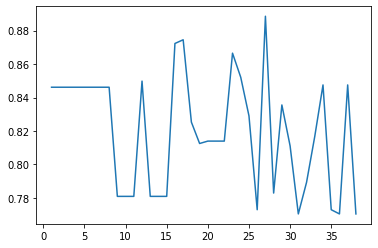

In [87]:
df_plot = df_training.query('bo_iteration>0')
import numpy as np
import matplotlib.pyplot as plt

x = df_plot['bo_iteration']
y = df_plot['loss']

plt.plot(x, y)
#plt.legend(title='Parameter where:')
plt.show()
#df.query('loss_estimate<0.010')

In [ ]:
#df.to_csv("./data/baxus.csv",index = None)